# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
* train.csv
* test.csv

#### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

#### Целевая переменная:
Price

#### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Содержание:

In [3256]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Дата и время
from datetime import datetime

import random as rnd
rnd.seed(42)

# разбиения выборки на тренировочнию и тестовую
from sklearn.model_selection import train_test_split

# Вычисление Z-score
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Алгоритм машинного обучения 'Метод случайного леса'
from sklearn.ensemble import RandomForestRegressor

# Кросс-валидация 
from sklearn.model_selection import cross_validate

# Разбиение
from sklearn.model_selection import KFold

# Метрика r2
from sklearn.metrics import r2_score as r2

In [3257]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print(df.dtypes)
    
    return df

Загружаем данные

In [3258]:
# Расположение данных
TEST_DATA = './test.csv'
TRAIN_DATA = './train.csv'

In [3259]:
train_data = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [3260]:
train_data.shape

(10000, 20)

In [3261]:
test_data = pd.read_csv(TEST_DATA, engine='python', on_bad_lines='skip')
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [3262]:
test_data.shape

(5000, 19)

Вывод: Тренировочный датасет содержит 10000 значений, тестовый - 5000

In [3263]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Уменьшим объем памяти, которую занимает датасет

In [3264]:
train_data = reduce_mem_usage(train_data)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object


In [3265]:
# Изменим имя двум признакам
train_data.rename(columns = {'Helthcare_2': 'Healthcare_2',
                             'DistrictId': 'District'}, inplace=True)

### Рассмотрим целевую переменную

In [3266]:
train_data['Price'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
10000 non-null  float32
dtypes: float32(1)
memory usage: 39.2 KB


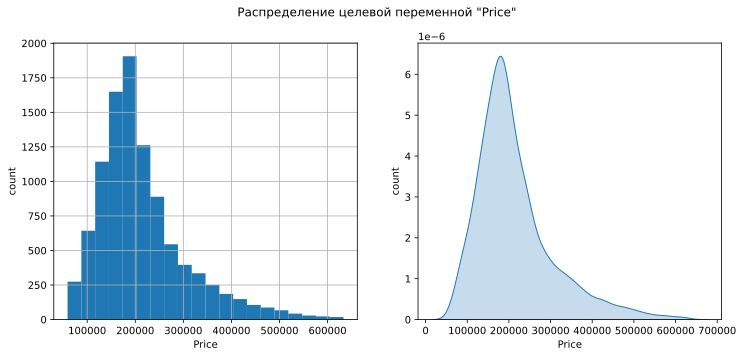

In [3267]:
plt.figure(figsize = (12, 5))

plt.subplot(121)
train_data['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_data['Price'], shade=True, legend=False)
plt.ylabel('count')
plt.xlabel('Price')

plt.suptitle('Распределение целевой переменной "Price"')
plt.show()

Вывод: целевая переменная распределена нормально с длинным хвостом справа, сильно заметных выбросов нет

## Рассмотрим набор признаков

In [3268]:
# выделим набор признаков в отдельную переменную (он пригодится нам позже)
feature_names = train_data.drop('Price', axis=1).columns

In [3269]:
# загрузим информацию о датасете
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   District       10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Healthcare_2   10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Описание данных <a class='anchor' id='description'>
- Id - идентификационный номер квартиры;
- DistrictId - идентификационный номер района;
- Rooms - количество комнат;
- Square - площадь;
- LifeSquare - жилая площадь;
- KitchenSquare - площадь кухни;
- Floor - этаж;
- HouseFloor - количество этажей в доме;
- HouseYear - год постройки дома;
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности;
- Social_1, Social_2, Social_3 - социальные показатели местности;
- Healtcare_1, Heltcare_2 - показатели местности, связанные с охраной здоровья;
- Shops_1, Shops_2 - показатели связанные с наличием магазинов, торговых центров;
- Price - цена квартиры.

In [3270]:
# посмотрим статистику по датасету
train_data.describe()

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [3271]:
# проверим датасет на дубликаты
duplicates = train_data.duplicated()
train_data[duplicates]

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price


Вывод: дубликатов нет

### Найдем пропущенные значения и заполним их

In [3272]:
# найдем пропущенные значения
train_data.isna().sum()

Id                  0
District            0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Healthcare_2        0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Вывод: пропущенные значения есть в двух столбцах 'LifeSquare' и 'Healthcare_1'

#####  **LifeSquare** - жилая площадь

Создадим столбец 'LifeSquare_nan' и заполним его 1, в тех строках, где были пропуски в столбце LifeSquare

In [3273]:
train_data['LifeSquare_nan'] = train_data['LifeSquare'].isna() * 1

In [3274]:
# пустые значения заменим медианой
train_data['LifeSquare'] = train_data['LifeSquare'].fillna(train_data['LifeSquare'].median())

##### **Healthcare_1**: 'показатели местности, связанные с охраной здоровья 1'

В этом столбце пропусков почти 50%. Такой признак может оказать существенное изменение на оценку модели, поэтому его можно удалить

In [3275]:
train_data.drop('Healthcare_1', axis=1, inplace=True)

In [3276]:
train_data.isna().sum()

Id                0
District          0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Healthcare_2      0
Shops_1           0
Shops_2           0
Price             0
LifeSquare_nan    0
dtype: int64

Вывод:  больше пропусков нет.

### Визуализируем признаки

Разделим признаки на численные и строковые

In [3277]:
def feature_separation(df):
    num_cols = []
    str_cols = []

    cols_and_type = df.dtypes.to_dict()

    for col in cols_and_type:
        if cols_and_type[col] in ('int64', 'float64', 'int16', 'int8', 'int32', 'float32'):
            num_cols.append(col)
        else: 
            str_cols.append(col)
            
    return num_cols, str_cols

In [3278]:
num_cols, str_cols = feature_separation(train_data)
f'Числовые признаки: {num_cols}'

"Числовые признаки: ['Id', 'District', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2', 'Shops_1', 'Price', 'LifeSquare_nan']"

In [3279]:
f'Строковые признаки: {str_cols}'

"Строковые признаки: ['Ecology_2', 'Ecology_3', 'Shops_2']"

Для удобства прочтения составим перевод признаков на основе описания данных

In [3280]:
translate = {
    'Id': 'идентификационный номер квартиры',
    'District': 'идентификационный номер района',
    'Rooms': 'количество комнат',
    'Square': 'площадь',
    'LifeSquare': 'жилая площадь',
    'KitchenSquare': 'площадь кухни',
    'Floor': 'этаж',
    'HouseFloor': 'количество этажей в доме',
    'HouseYear': 'год постройки дома',
    'Ecology_1': 'экологические показатели местности_1',
    'Ecology_2': 'экологические показатели местности_2',
    'Ecology_3': 'экологические показатели местности_3',
    'Social_1': 'социальные показатели местности_1',
    'Social_2': 'социальные показатели местности_2',
    'Social_3': 'социальные показатели местности_3',
    'Healthcare_1': 'показатели местности, \nсвязанные с охраной здоровья 1',
    'Healthcare_2': 'показатели местности, \nсвязанные с охраной здоровья 2',
    'Shops_1': 'показатели связанные с наличием \n магазинов, торговых центров 1',
    'Shops_2': 'показатели связанные с наличием \nмагазинов, торговых центров 2',
    'Price': 'цена квартиры',
    'LifeSquare_nan': 'пропуски в LifeSquare'
}

### Визуализируем числовые признаки

In [3281]:
def visual_num_feature(data, captions):
    plt.figure(figsize=[11, 13])
    # Общий заголовок
    plt.suptitle(f'Распределение числовых признаков',
                    fontsize=16, 
                    fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(6, 3, i+1)
        # Заголовок для графика
        plt.title(f'\n{col} \n({captions[col]})', fontsize=10)

        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        
        plt.hist(data[col])

        # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

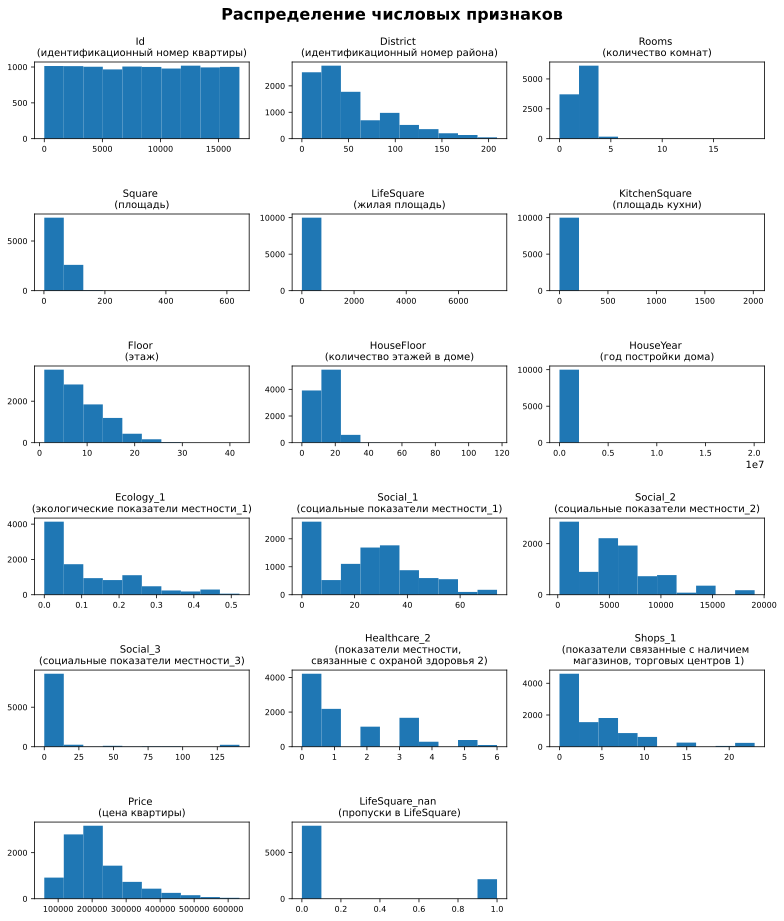

In [3282]:
visual_num_feature(train_data, translate)

Вывод: По графикам видно, что есть значительные выбросы почти по всем столбцам. Подробнее каждый столбец рассмотрим ниже

In [3283]:
def visual_str_feature(data, captions):
    plt.figure(figsize=[11, 5])

    plt.suptitle(f'Распределение строковых признаков', 
                    fontsize=16, 
                    fontweight='bold')
    
    for i, col in enumerate(str_cols):
        plt.subplot(2, 3, i+1)
        plt.title(f'\n{col} \n({captions[col]})', fontsize=10)

        plt.hist(data[col], bins=2)
    plt.tight_layout()

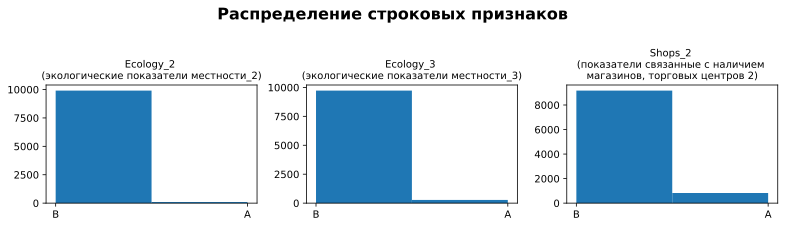

In [3284]:
visual_str_feature(train_data, translate)

Вывод: строковые признаки распределены неравномерно, но из-за недостатка информации невозможно оценить значение этих показателей

### Выбросы

#### Исследуем столбец **'Rooms'** - количество комнат

In [3285]:
# проверим уникальные значения
train_data['Rooms'].unique()

array([ 2.,  3.,  1.,  4., 10.,  0.,  5., 19.,  6.], dtype=float32)

In [3286]:
# и количество значений
train_data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Вывод: пока очевидно можно сказать, что наблюдаются выбросы по значениям 5, 0, 10, 19, 6

<Axes: ylabel='Rooms'>

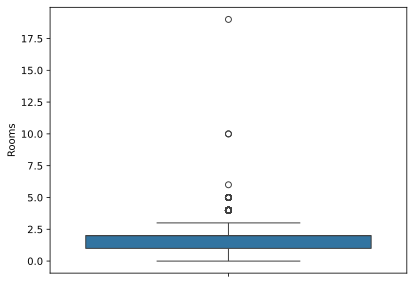

In [3287]:
# чтобы убедиться в этом построим ящик с усами
sns.boxplot(train_data['Rooms'])

Вывод:  на графике видно, явный выбросы больше 5 и значения 4 тоже лежат выше 3 квантиля

In [3288]:
# посмотрим есть ли квартиры с 5 комнатами и площадью больше 100 - такие квартиры реально могут существовать
train_data[(train_data['Rooms'] == 5) & (train_data['Square'] > 100)]

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
1503,1243,86,5.0,108.057396,82.723824,8.0,3,5.0,1942,0.161976,B,A,31,7010,5,3,7,B,310305.06250,0
1982,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,3,7,B,455264.87500,0
3268,8901,34,5.0,121.577423,114.913841,1.0,25,1.0,1977,0.069753,B,B,53,13670,4,1,11,B,455446.40625,0
4487,13434,13,5.0,183.382278,100.985504,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,5,15,B,622888.81250,0
4762,4070,21,5.0,114.313751,88.492653,9.0,6,5.0,1960,0.034331,B,B,25,5487,3,0,4,B,499830.93750,0
5361,2879,78,5.0,118.871948,69.023506,10.0,15,16.0,1998,0.092291,B,B,21,4346,2,1,2,B,496026.65625,0
5466,3454,8,5.0,112.135521,79.795448,10.0,4,17.0,1999,0.437885,B,B,23,5735,3,0,5,B,471833.78125,0
6623,3294,167,5.0,111.045799,81.940460,9.0,6,6.0,1940,0.050272,B,B,21,4231,14,0,3,B,513239.50000,0
6988,8685,62,5.0,124.933289,81.122368,30.0,5,3.0,2017,0.072158,B,B,2,629,1,0,0,A,271919.87500,0
8511,4249,23,5.0,198.930176,123.139862,10.0,1,2.0,2011,0.014073,B,B,2,475,0,0,0,B,345665.21875,0


Вывод: Да, такие квартиры есть. Тогда за выброс будем считать квартиры меньше 1 комнаты  и больше 5 комнат и площадью меньше 100. Заменим такие значения на медиану

In [3289]:
# создадим маску для нашего условия
index_rooms = train_data.query('(Rooms < 1) | ((Rooms >= 5) & (Square < 100))').index
index_rooms

Int64Index([ 377, 1397, 1422, 1454, 1981, 2170, 2269, 3271, 3911, 4366, 4431,
            4853, 6149, 8726, 8834, 8849, 8925],
           dtype='int64')

Сделаем дополнительный признак Rooms_outlier, где со значением 1 укажем строки, соответствующие выбросам в столбце Rooms

In [3290]:
train_data['Rooms_outlier'] = 0
train_data.loc[index_rooms, 'Rooms_outlier'] = 1
train_data.head(3)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,0,11,B,184966.93750,0,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,1,16,B,300009.43750,0,0
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,1,3,B,220925.90625,0,0


In [3291]:
train_data.loc[index_rooms, ['Rooms']] = train_data['Rooms'].median()

#### Исследуем столбцы **'Square', 'LifeSquare', 'KitchenSquare'** - все, что связано с площадью

In [3292]:
SquareList = ['Square', 'LifeSquare', 'KitchenSquare']

In [3293]:
# посмотри что из себя представляют данные
train_data[SquareList].sample(10)

,Square,LifeSquare,KitchenSquare
6302,32.246403,20.636097,5.0
4925,57.101128,28.403240,8.0
4561,74.642235,74.164322,1.0
8003,60.619141,37.543095,10.0
6364,55.167583,33.957916,9.0
7802,43.607094,32.781261,1.0
3512,39.392006,24.574011,8.0
2978,64.623840,46.095627,7.0
9287,63.523148,32.781261,1.0
950,40.603374,21.724201,10.0


Вывод: Общая и Жилая площадь представляет число с 6 знаками после запятой, такое врядли встречается в реальной жизни. Округлим эти числа до целого

In [3294]:
train_data['Square'] = train_data['Square'].apply(lambda x: np.round(x, 0))
train_data['LifeSquare'] = train_data['LifeSquare'].apply(lambda x: np.round(x, 0))

In [3295]:
train_data[SquareList].head(5)

,Square,LifeSquare,KitchenSquare
0,48.0,29.0,6.0
1,66.0,40.0,8.0
2,45.0,29.0,0.0
3,53.0,53.0,9.0
4,40.0,24.0,7.0


In [3296]:
# посмотрим статистику по выбранным столбцам
train_data[SquareList].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.309700,36.314500,6.273300
std,21.062981,76.613351,28.560917
min,1.000000,0.000000,0.000000
25%,42.000000,26.000000,1.000000
50%,53.000000,33.000000,6.000000
75%,66.000000,41.000000,9.000000
max,641.000000,7481.000000,2014.000000


Вывод: Видим аномально большие максимальные значения всех столбцов

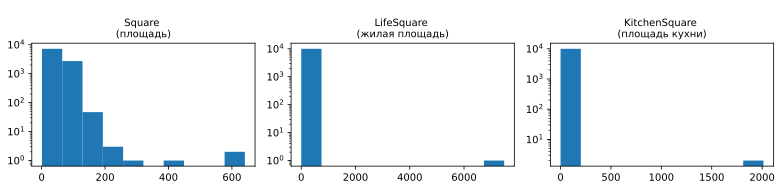

In [3297]:
# убедимся в этом, построив гистограммы и применив к ним логарифическую функцию
plt.figure(figsize=[11, 13])

for i, col in enumerate(SquareList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col], log=True)
    plt.title(f'\n{col} \n({translate[col]})', fontsize=10)


plt.tight_layout()

Вывод: Большие значения подтверждаются

In [3298]:
train_data.Square.median()

53.0

In [3299]:
# заменим аномально большие значение и значения меньше 5 на медиану
train_data.loc[((train_data['Square'] > 400) | (train_data['Square'] < 5)), ['Square']] = train_data['Square'].median()

# также заменим значения жилой площади и кухни на медианную, если они больше жилой (т.е 400)
train_data.loc[(train_data['LifeSquare'] > train_data['Square'].max()), ['LifeSquare']] = train_data['LifeSquare'].median()
train_data.loc[(train_data['KitchenSquare'] > train_data['Square'].max()), ['KitchenSquare']] = train_data['KitchenSquare'].median()

посмотрим выбросы на ящике с усами

<Axes: >

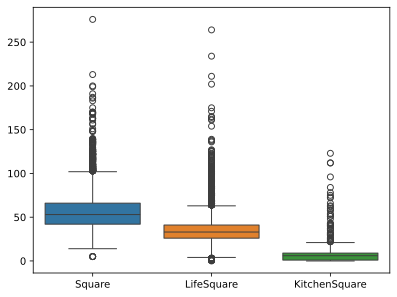

In [3300]:
sns.boxplot(train_data[SquareList])

In [3301]:
# заменим все значения площади кухни больше 30 на медиану
train_data.loc[(train_data['KitchenSquare'] >= 30), ['KitchenSquare']] = train_data['KitchenSquare'].median()

Так же должны соблюдаться следующие условия:

* Общая площадь > Жилой площади (это очевидно)
* Общая площадь > Площади кухни (аналогично)
* Площадь кухни < Общая площадь - Жилая площадь (еще есть коридор, туалет и балкон)

In [3302]:
# Если общая площадь меньше жилой, то ее значение меняем на LifeSquare + KitchenSquare
train_data.loc[(train_data['Square'] <= train_data['LifeSquare']), ['Square']] = train_data['LifeSquare'] + train_data['KitchenSquare']

In [3303]:
# Если жилая площадь меньше кухни, то заменим ее на Square - KitchenSquare
train_data.loc[(train_data['LifeSquare'] <= train_data['KitchenSquare']), ['LifeSquare']] = train_data['Square'] - train_data['KitchenSquare']

In [3304]:
# заменим площадь кухни, если она больше разницы общей и жилой площадей
train_data.loc[(train_data['KitchenSquare'] > (train_data['Square'] - train_data['LifeSquare'])), ['KitchenSquare']] = train_data['Square'] - train_data['LifeSquare']

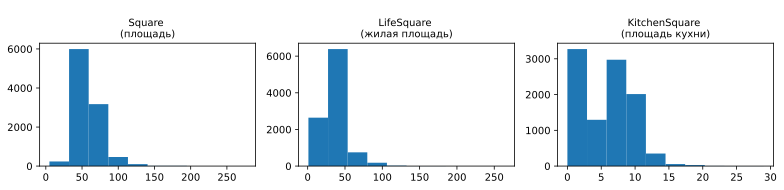

In [3305]:
# еще раз посмотри гистограмму
plt.figure(figsize=[11, 13])

for i, col in enumerate(SquareList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col])
    plt.title(f'\n{col} \n({translate[col]})', fontsize=10)

plt.tight_layout()

Вывод: хоть данные визуально и не распределены нормально (имеется большой хвост справа), я не считаю нужным дальше подчищать их. Так как квартиры с такими параметрами имеют место быть в реальности

In [3306]:
train_data[SquareList].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.522400,35.595000,5.554800
std,19.322961,16.019414,3.891723
min,5.000000,1.000000,0.000000
25%,42.000000,26.000000,1.000000
50%,53.000000,33.000000,6.000000
75%,66.000000,42.000000,8.000000
max,276.000000,264.000000,29.000000


Вывод: после всех манипуляций с данными столбцами основные статистические данные сильно не изменились (кроме стандартного отклонения, но это из-за изменения максимальных значений)

#### Исследуем столбцы **'Floor'** и **'HouseFloor'**

In [3307]:
FloorList = ['Floor', 'HouseFloor']

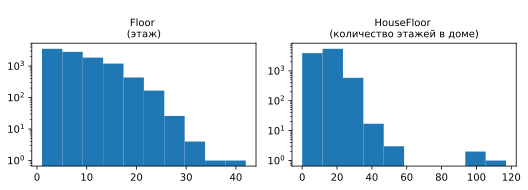

In [3308]:
plt.figure(figsize=[11, 13])

for i, col in enumerate(FloorList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col], log=True)
    plt.title(f'\n{col} \n({translate[col]})', fontsize=10)

plt.tight_layout()

In [3309]:
# посомтрим уникальные значения в обоих столбцах
for el in FloorList:
    print(train_data[el].unique())

[ 7  8 11  5  3 14  9 13  1  6  4 16 12 15 19  2 17 20 10 18 26 23 22 24
 21 25 32 28 27 42 31 37 33]
[  9.  12.  17.   5.   0.   8.   4.  14.  25.   1.  22.  16.  15.   3.
  10.  11.   7.  24.  28.  19.  20.  18.  23.   2.  32.  40.  27.  21.
  13.  45.  30.   6.  37.  48.  47.  44.  39.  36.  29.  99.  38. 117.
  26.  31.]


Вывод: В столбще этажности дома вызывают сомнение значения больше 50 и меньше 1 этажей

In [3310]:
# заменим такие значения на медиану
train_data.loc[((train_data['HouseFloor'] > 50) | (train_data['HouseFloor'] < 1)), 'HouseFloor'] = train_data['HouseFloor'].median()

In [3311]:
# также стоит проверить значения, где указанный этаж больше количества этажей в доме
index_floor = train_data.loc[(train_data['Floor'] > train_data['HouseFloor']), 'HouseFloor'].index
index_floor

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

Вывод: таких значений 1825 штук

In [3312]:
# создадим дополнительный столбец Floor_outlier и заполним его 1, если данное условие верное
train_data['Floor_outlier'] = 0
train_data.loc[index_floor, 'Floor_outlier'] = 1
train_data.head(3)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier
0,14038,35,2.0,48.0,29.0,6.0,7,9.0,1969,0.089040,...,33,7976,5,0,11,B,184966.93750,0,0,0
1,15053,41,3.0,66.0,40.0,8.0,7,9.0,1978,0.000070,...,46,10309,1,1,16,B,300009.43750,0,0,0
2,4765,53,2.0,45.0,29.0,0.0,8,12.0,1968,0.049637,...,34,7759,0,1,3,B,220925.90625,0,0,0


In [3313]:
# заменим эти значения на случайное число в соответствие от этажности дома

train_data.loc[index_floor, 'Floor'] = train_data.loc[index_floor, 'HouseFloor'].apply(lambda x: rnd.randint(1, x))

In [3314]:
# проверим все ли у нас получилось
train_data[(train_data['Floor'] > train_data['HouseFloor'])]

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier


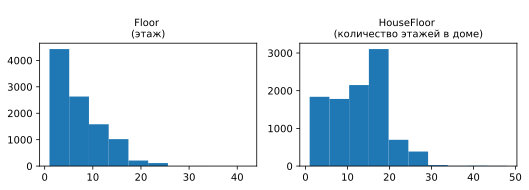

In [3315]:
plt.figure(figsize=[11, 13])

for i, col in enumerate(FloorList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col])#, log=True)
    plt.title(f'\n{col} \n({translate[col]})', fontsize=10)

plt.tight_layout()

In [3316]:
train_data[FloorList].describe()

,Floor,HouseFloor
count,10000.000000,10000.000000
mean,7.416000,12.931500
std,5.025144,6.241322
min,1.000000,1.000000
25%,3.000000,9.000000
50%,6.000000,13.000000
75%,11.000000,17.000000
max,42.000000,48.000000


Вывод: Статистические показатели практически не изменились

#### Исследуем признак **'HouseYear'** - год постройки дома

In [3317]:
# Посмотрим даты, которые больше текущей даты 
train_data[train_data['HouseYear'] > datetime.now().year].HouseYear

1497    20052011
4189        4968
Name: HouseYear, dtype: int32

Вывод: таких значений 2. Первое, скорее всего, связано с попыткой указать временной интервал строительства дома, второй - с опечаткой

In [3318]:
# поменяем их вручную
train_data.loc[train_data['HouseYear'] == 20052011, 'HouseYear'] = 2011
train_data.loc[train_data['HouseYear'] == 4968, 'HouseYear'] = 1968

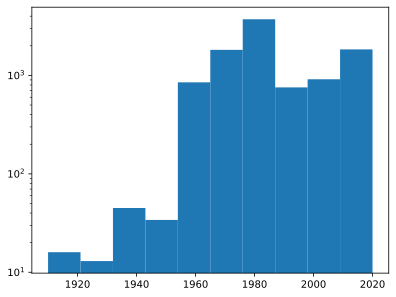

In [3319]:
plt.hist(train_data['HouseYear'], log=True)
plt.show()

In [3320]:
train_data['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1914       1
1947       1
1916       1
1910       1
1928       1
Name: HouseYear, Length: 95, dtype: int64

In [3321]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              10000 non-null  int16   
 1   District        10000 non-null  int16   
 2   Rooms           10000 non-null  float32 
 3   Square          10000 non-null  float64 
 4   LifeSquare      10000 non-null  float64 
 5   KitchenSquare   10000 non-null  float32 
 6   Floor           10000 non-null  int64   
 7   HouseFloor      10000 non-null  float32 
 8   HouseYear       10000 non-null  int32   
 9   Ecology_1       10000 non-null  float32 
 10  Ecology_2       10000 non-null  category
 11  Ecology_3       10000 non-null  category
 12  Social_1        10000 non-null  int8    
 13  Social_2        10000 non-null  int16   
 14  Social_3        10000 non-null  int16   
 15  Healthcare_2    10000 non-null  int8    
 16  Shops_1         10000 non-null  int8    
 17  Shops_2      

In [3322]:
# изменим тип переменных 
train_data[['Id', 'District']] = train_data[['Id', 'District']].astype(str)

In [3323]:
binary_to_numbers = {'A': 0, 'B': 1}

train_data['Ecology_2'] = train_data['Ecology_2'].replace(binary_to_numbers)
train_data['Ecology_3'] = train_data['Ecology_3'].replace(binary_to_numbers)
train_data['Shops_2'] = train_data['Shops_2'].replace(binary_to_numbers)

### Создаем класс подготовки исходных данных

In [3324]:
class DataPipeline:
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None

    def reduce_mem_usage(self, df):
        """Уменьшение объема памяти"""
        start_mem = df.memory_usage().sum() / 1024**2
        print('Используемая память {:.2f} MB'.format(start_mem))
        
        for col in df.columns:
            col_type = df[col].dtype
            
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Память после оптимизации: {:.2f} MB'.format(end_mem))
        print('Уменьшено на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print(df.dtypes)
    

    def change_of_type(self, df):
        """Изменение типа переменных и переименование столбцов"""
        df[['Id', 'DistrictId']] = df[['Id', 'DistrictId']].astype(str)
        
        df.rename(columns = {'Helthcare_2': 'Healthcare_2',
                             'DistrictId': 'District'}, inplace=True)
        return df
    

    def fit(self, df):
        """Сохранение статистик"""
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.house_year_mode = df['HouseYear'].mode()[0]
        self.rooms_median = df['Rooms'].median()
        self.square_median = df['Square'].median()
        self.kitchen_square_median = df['KitchenSquare'].median()
        self.life_square_median = df['LifeSquare'].median()
        self.house_floor_median = df['HouseFloor'].median()

    def transform(self, df):
        """Трансформация данных"""
        
        df = self.change_of_type(df)
        
        # Binary features
        df['Ecology_2'] = df['Ecology_2'].replace(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].replace(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].replace(self.binary_to_numbers)
        
        # 1. убираем пропуски
        
        # смотрим пустые значения
        empty_values = df.isna().sum()
        for i, j in empty_values.items():
            # отбираем столбы с пропусками
            if j > 0:
                # если количество пропусков больше 40%, то такой столбец удаляем
                if j / df.shape[0] > 0.3:
                    # значения убираем
                    df.drop(i, axis=1, inplace=True)
                else:
                    # остальное заменяем на медиану
                    df[i+'_nan'] = df[i].isna() * 1
                    df[i] = df[i].fillna(df[i].median())


        # 2. Выбросы (outliers)

        # 'Rooms'
        index_rooms = df.query('(Rooms < 1) | ((Rooms >= 5) & (Square < 100))').index
        df['Rooms_outlier'] = 0
        df.loc[index_rooms, 'Rooms_outlier'] = 1
        df.loc[index_rooms, ['Rooms']] = self.rooms_median

        # 'HouseYear'
        df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
        df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968

        # 'Square', 'LifeSquare', 'KitchenSquare'
        df['Square'] = df['Square'].apply(lambda x: np.round(x, 0))
        df['LifeSquare'] = df['LifeSquare'].apply(lambda x: np.round(x, 0))

        df.loc[((df['Square'] > 400) | (df['Square'] < 5)), ['Square']] = df['Square'].median()
        df.loc[(df['LifeSquare'] > df['Square'].max()), ['LifeSquare']] = df['LifeSquare'].median()
        df.loc[(df['KitchenSquare'] > df['Square'].max()), ['KitchenSquare']] = df['KitchenSquare'].median()
        df.loc[(df['KitchenSquare'] >= 30), ['KitchenSquare']] = df['KitchenSquare'].median()
        df.loc[(df['KitchenSquare'] >= 30), ['KitchenSquare']] = self.kitchen_square_median
        df.loc[(df['Square'] <= df['LifeSquare']), ['Square']] = df['LifeSquare'] + df['KitchenSquare']
        df.loc[(df['LifeSquare'] <= df['KitchenSquare']), ['LifeSquare']] = df['Square'] - df['KitchenSquare']
        df.loc[(df['KitchenSquare'] > (df['Square'] - df['LifeSquare'])), ['KitchenSquare']] = df['Square'] - df['LifeSquare']

        # 'Floor', 'HouseFloor'
        df.loc[((df['HouseFloor'] > 50) | (df['HouseFloor'] < 1)), 'HouseFloor'] = self.house_floor_median
        rnd.seed(42)
        index_floor = df.loc[(df['Floor'] > df['HouseFloor'])].index
        df['Floor_outlier'] = 0
        df.loc[index_floor, 'Floor_outlier'] = 1
        df.loc[index_floor, 'Floor'] = df.loc[index_floor, 'HouseFloor'].apply(lambda x: rnd.randint(1, x))
        
        return df


### Проверяем работу класса

In [3325]:
# подгружаем датасет
train_data_new = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data_new.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [3326]:
# создаем экземпляр класса
dp = DataPipeline()

In [3327]:
# применяем функцию уменьшения памяти
dp.reduce_mem_usage(train_data_new)

Используемая память 1.53 MB
Память после оптимизации: 0.49 MB
Уменьшено на 68.1%
Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object


In [3328]:
# сохоаняем статистики
dp.fit(train_data_new)

In [3329]:
# проводим трансформацию данных и сохраняем в новый датафрейм
proverka = dp.transform(train_data_new)

In [3330]:
# проверяем на сходство с разобранным датафреймом
proverka.equals(train_data)

True

In [3331]:
# проверяем по столбцам (чтобы знать в каком столбце искать ошибку)
for el in train_data.columns:
    print(el, proverka[el].equals(train_data[el]))


Id True
District True
Rooms True
Square True
LifeSquare True
KitchenSquare True
Floor True
HouseFloor True
HouseYear True
Ecology_1 True
Ecology_2 True
Ecology_3 True
Social_1 True
Social_2 True
Social_3 True
Healthcare_2 True
Shops_1 True
Shops_2 True
Price True
LifeSquare_nan True
Rooms_outlier True
Floor_outlier True


Вывод: Написанный класс отработал как надо.

## Построение новых признаков

In [3332]:
train_data[['Ecology_2','Ecology_3', 'Shops_2']].sample(5)

,Ecology_2,Ecology_3,Shops_2
7885,1,1,1
4268,1,1,0
3254,1,1,1
6938,1,1,1
2761,1,1,1


Предположим, что район влиет на цену квартиры, для этого введем новый признак

In [3333]:
# Посмотрим кол-во квартир по разным районам
dc = train_data['District'].value_counts()
dc

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: District, Length: 205, dtype: int64

In [3334]:
# сделаем из этих данных датафрейм
# сбросим индексы и заменим названия столбцов
district_count = dc.reset_index().rename(columns={'index': 'District', 'District': 'DistrictCount'})
# district_count = dc.reset_index().rename(columns={'count': 'DistrictCount'})
district_count.head(5)

,District,DistrictCount
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [3335]:
# добавим столбец DistrictCount в наш датафрейм путем слияния двух датафреймов по общему столбцу District
train_data = train_data.merge(district_count, on='District', how='left')
train_data.head(5)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier,DistrictCount
0,14038,35,2.0,48.0,29.0,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.937500,0,0,0,22
1,15053,41,3.0,66.0,40.0,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.437500,0,0,0,87
2,4765,53,2.0,45.0,29.0,0.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.906250,0,0,0,174
3,5809,58,2.0,62.0,53.0,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.234375,0,0,0,179
4,10783,99,1.0,40.0,24.0,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531250,0,0,0,97


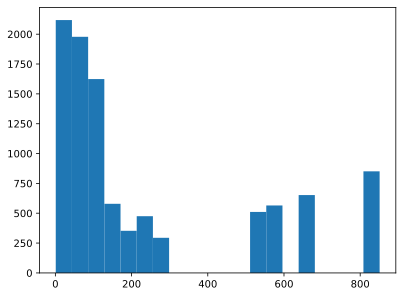

In [3336]:
# посмотрим распределение
plt.hist(train_data['DistrictCount'], bins=20);

Вывод: больше всего квартир продается в районах с индексом меньше 100. Вероятно, что эти районы больше по размеру

In [3337]:
(train_data['DistrictCount'] < 100).value_counts()

False    5069
True     4931
Name: DistrictCount, dtype: int64

In [3338]:
# добавим признак isDistrictLarge, где укажем большой район или нет
train_data['isDistrictLarge'] = 1
train_data.loc[train_data['DistrictCount'] < 100, 'isDistrictLarge'] = 0
train_data.head(3)


,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier,DistrictCount,isDistrictLarge
0,14038,35,2.0,48.0,29.0,6.0,7,9.0,1969,0.089040,...,5,0,11,1,184966.93750,0,0,0,22,0
1,15053,41,3.0,66.0,40.0,8.0,7,9.0,1978,0.000070,...,1,1,16,1,300009.43750,0,0,0,87,0
2,4765,53,2.0,45.0,29.0,0.0,8,12.0,1968,0.049637,...,0,1,3,1,220925.90625,0,0,0,174,1


Рассмотри матрицу корреляции, чтоб выделить еще несколько новых признаков

In [3339]:
corr_m = train_data.corr()

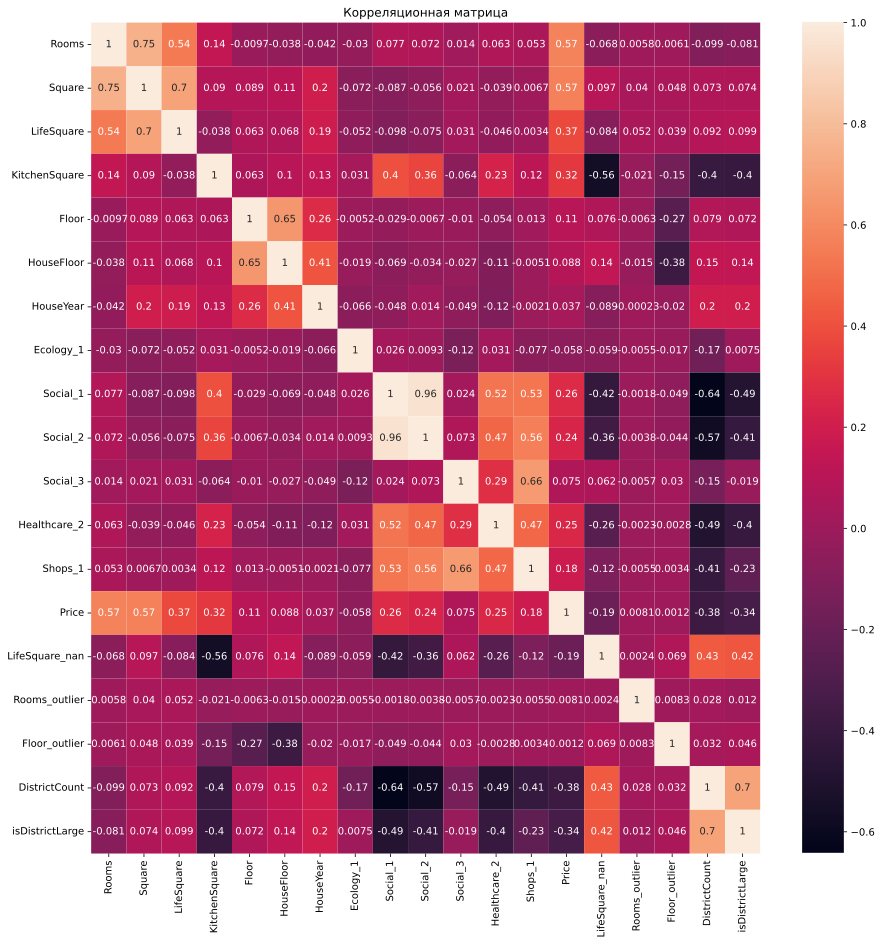

In [3340]:
plt.figure(figsize = (15, 15))
plt.title('Корреляционная матрица')
sns.heatmap(corr_m, annot = True)
plt.show()

По матрице корреляции можно сделать следующие выводы:
1) Очевидна зависимость между Кол-во комнат, Площадью и Жилой площадью, а также Этажом от Этажности дома. Также очеведна зависимость Цены квартиры от Площади и Кол-ва комнат
2) Любопытно выделить зависимость Этажности дома от Года его постройки. Факт, который часто остается без внимания
3) Прослеживается зависимость между Social_1, Social_2, Social_3 и Shops_1
4) Если оценивать новые параметры (Кол-во квартир в районе, Размер района), то видно, что они коррелируют с таким признаками как Social_1, Social_2, Healtcare_1, Shops_1 - возможно предположить, что чем больше район, тем развитее в нем инфраструктура.
5) Также есть зависимость Цены от признаков Районов

### **'MedPriceDistrict'** - средняя цена квартиры по районам

In [3341]:
# сгруппируем значения по столбцам Район и Комнаты и найдем для каждой группы среднее значение по цене
med_price_district = train_data.groupby(['District', 'Rooms'], as_index=False).agg({'Price':'median'})
# изменим название 'Price' на 'MedPriceDistrict'
med_price_district = med_price_district.rename(columns={'Price': 'MedPriceDistrict'})

med_price_district.head()

,District,Rooms,MedPriceDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.359375
3,1,1.0,146735.671875
4,1,2.0,202666.312500


### **'MedPriceFloorYear''** - средняя цена квартиры в зависимости от Этажности дома и его Года постройки

In [3342]:
# посмотрим уникальные значения в столбце HouseFloor
train_data['HouseFloor'].unique()

array([ 9., 12., 17.,  5., 13.,  8.,  4., 14., 25.,  1., 22., 16., 15.,
        3., 10., 11.,  7., 24., 28., 19., 20., 18., 23.,  2., 32., 40.,
       27., 21., 45., 30.,  6., 37., 48., 47., 44., 39., 36., 29., 38.,
       26., 31.], dtype=float32)

Вывод: Из результатов видно, что представлены дома разной этажности от 1 до 48. Выделим следующие категории: частные дома (1-2 этажа), малоэтажные (от 3 до 5 этажей), средней этажности (от 5 до 9), многоэтажки (от 10 до 18), выше 19 этажей.

In [3343]:
train_data['FloorCat'] = 0
train_data.loc[(train_data['HouseFloor'] < 3), 'FloorCat'] = 1
train_data.loc[(train_data['HouseFloor'] >= 3) & (train_data['HouseFloor'] <= 5), 'FloorCat'] = 2
train_data.loc[((train_data['HouseFloor'] > 5) & (train_data['HouseFloor'] <= 9)), 'FloorCat'] = 3
train_data.loc[((train_data['HouseFloor'] > 9) & (train_data['HouseFloor'] <= 18)), 'FloorCat'] = 4
train_data.loc[(train_data['HouseFloor'] > 18), 'FloorCat'] = 4

train_data.head(3)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier,DistrictCount,isDistrictLarge,FloorCat
0,14038,35,2.0,48.0,29.0,6.0,7,9.0,1969,0.089040,...,0,11,1,184966.93750,0,0,0,22,0,3
1,15053,41,3.0,66.0,40.0,8.0,7,9.0,1978,0.000070,...,1,16,1,300009.43750,0,0,0,87,0,3
2,4765,53,2.0,45.0,29.0,0.0,8,12.0,1968,0.049637,...,1,3,1,220925.90625,0,0,0,174,1,4


In [3344]:
# теперь посмотрим унникальные значения в столбце Год постройки
train_data['HouseYear'].unique()

array([1969, 1978, 1968, 1977, 1976, 2011, 1960, 2014, 1973, 1959, 1999,
       1980, 1979, 1983, 2001, 2012, 2002, 1996, 1964, 2018, 1972, 1965,
       1984, 1961, 1971, 1963, 2017, 1970, 1981, 2003, 2016, 1991, 1975,
       2006, 2009, 1985, 1974, 1994, 2000, 1987, 1998, 2005, 1990, 1982,
       1997, 2015, 2008, 2010, 2004, 2007, 1967, 1957, 1962, 1993, 1966,
       1955, 1937, 1992, 1954, 1995, 2019, 1948, 1986, 2013, 1989, 1958,
       1938, 1956, 1988, 2020, 1951, 1952, 1935, 1914, 1932, 1950, 1917,
       1918, 1940, 1942, 1939, 1934, 1931, 1919, 1912, 1953, 1936, 1947,
       1929, 1930, 1933, 1941, 1916, 1910, 1928])

In [3345]:
# Выделим 7 временных интервалов постройки домов
train_data['YearCat'] = 0

train_data.loc[(train_data['HouseYear'] <= 1953), 'YearCat'] = 1
train_data.loc[(train_data['HouseYear'] > 1953) & (train_data['HouseYear'] <= 1960), 'YearCat'] = 2
train_data.loc[(train_data['HouseYear'] > 1960) & (train_data['HouseYear'] <= 1970), 'YearCat'] = 3
train_data.loc[(train_data['HouseYear'] > 1970) & (train_data['HouseYear'] <= 1980), 'YearCat'] = 4
train_data.loc[(train_data['HouseYear'] > 1980) & (train_data['HouseYear'] <= 2000), 'YearCat'] = 5
train_data.loc[(train_data['HouseYear'] > 2000) & (train_data['HouseYear'] <= 2010), 'YearCat'] = 6
train_data.loc[(train_data['HouseYear'] >= 2010), 'YearCat'] = 7

train_data.sample(5)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier,DistrictCount,isDistrictLarge,FloorCat,YearCat
4683,12654,52,3.0,79.0,47.0,10.0,20,22.0,2005,0.371149,...,5,1,401305.562500,0,0,0,143,1,4,6
3640,8600,58,1.0,53.0,33.0,1.0,3,9.0,1977,0.437885,...,5,1,118166.476562,1,0,0,179,1,3,4
9185,6225,156,1.0,40.0,23.0,7.0,13,17.0,2010,0.007659,...,19,1,269691.718750,0,0,0,10,0,4,7
1593,9418,9,2.0,67.0,6.0,1.0,1,1.0,1977,0.161532,...,4,1,183976.843750,0,0,1,294,1,1,4
2701,12469,58,3.0,78.0,45.0,10.0,4,17.0,1997,0.050756,...,1,1,313756.000000,0,0,0,179,1,4,5


In [3346]:
# сгруппируем значения по новым столбцам FloorCat и YearCat и найдем для каждой группы среднее значение по цене
med_price_floor_year = train_data.groupby(['FloorCat', 'YearCat'], as_index=False).agg({'Price':'median'})
# изменим название 'Price' на 'MedPriceFloorYear'
med_price_floor_year = med_price_floor_year.rename(columns={'Price': 'MedPriceFloorYear'})

med_price_floor_year.head(10)

,FloorCat,YearCat,MedPriceFloorYear
0,1,3,200507.242188
1,1,4,180910.953125
2,1,5,222500.570312
3,1,6,185239.625000
4,1,7,208773.984375
5,2,1,296625.515625
6,2,2,232563.507812
7,2,3,178077.687500
8,2,4,142843.984375
9,2,5,154850.851562


In [3347]:
# запишем новые столбцы в наш датафрейм
train_data = train_data.merge(med_price_floor_year, on=['FloorCat', 'YearCat'], how='left')
train_data = train_data.merge(med_price_district, on=['District', 'Rooms'], how='left')


### **'isFirstLastFloor'** - первый или последний этаж в доме

При покупке квартиры многие обращают внимание на этаж, а именно, чтобы не было первого и последнего

In [3348]:
# выделим маску и создадим новый признак, соответствует ли этаж квартиры выбранным условиям
first_large = train_data.query('(Floor == 1) | (Floor == (HouseFloor))').index
train_data['isFirstLargeFloor'] = 0
train_data.loc[first_large, 'isFirstLargeFloor'] = 1

In [3349]:
train_data.sample(10)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,Rooms_outlier,Floor_outlier,DistrictCount,isDistrictLarge,FloorCat,YearCat,MedPriceFloorYear,MedPriceDistrict,isFirstLargeFloor
2708,12570,62,3.0,138.0,137.0,1.0,1,3.0,1977,0.072158,...,0,0,1,247,1,2,4,142843.984375,213915.960938,1
3505,13448,45,2.0,45.0,27.0,5.0,9,9.0,1966,0.014423,...,0,0,0,116,1,3,3,200322.984375,327660.375000,1
9841,10524,23,3.0,75.0,33.0,1.0,5,17.0,1977,0.075779,...,1,0,0,565,1,4,4,179037.093750,166687.734375,0
6700,483,21,1.0,40.0,23.0,8.0,15,17.0,1997,0.194489,...,0,0,0,165,1,4,5,231813.890625,153921.398438,0
8215,8934,7,1.0,40.0,33.0,1.0,1,1.0,1977,0.000000,...,1,0,1,92,0,1,4,180910.953125,187116.906250,1
7941,12174,62,1.0,45.0,33.0,0.0,8,13.0,1977,0.072158,...,1,0,0,247,1,4,4,179037.093750,129107.218750,0
2977,5757,52,3.0,80.0,33.0,1.0,15,17.0,1977,0.371149,...,1,0,0,143,1,4,4,179037.093750,204462.984375,0
434,1933,23,2.0,65.0,33.0,1.0,8,17.0,1977,0.075779,...,1,0,0,565,1,4,4,179037.093750,142883.015625,0
3147,5813,123,2.0,76.0,36.0,13.0,7,12.0,2009,0.000000,...,0,0,0,32,0,4,6,247606.304688,321106.312500,0
1250,2275,176,2.0,55.0,35.0,8.0,13,16.0,1981,0.300323,...,0,0,0,6,0,4,5,231813.890625,255449.062500,0


### Создадим класс Новых признаков и проверим его работу

In [3350]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.district_count = None
        
    def fit(self, df, y):
        # df - набор признаков
        # y - целевая переменная
        df = df.copy()

        # кол-во квартир в разных районах
        self.dc = df['District'].value_counts()
        # создаем столбец 'DistrictCount'
        self.dictrict_count = dc.reset_index().rename(columns={'index': 'District', 'District': 'DistrictCount'})
        # self.district_count = dc.reset_index().rename(columns={'count': 'DistrictCount'})

        data = df.copy()

        if y is not None:
            # добавляем целевую переменную в датафрейм
            data['Price'] = y.values
            
            # вычисляем среднюю цену по Комнатам в каждом районе
            self.med_price_district = data.groupby(['District', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price': 'MedPriceDistrict'})
        
        if y is not None:
            # добавляем целевую переменную в датафрейм
            data['Price'] = y.values        
            # создаем категории для Этажности и Года постройки
            data = self.floor_to_cat(data)
            data = self.year_to_cat(data)
            # вычисляем среднюю цену по Этажности дома и Году его постройки
            self.med_price_floor_year = data.groupby(['FloorCat', 'YearCat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price': 'MedPriceFloorYear'})
                    
    def transform(self, df):    
    
        # DistrictCount, IsDistrictLarge
        df = df.merge(self.dictrict_count.rename(columns={'count': 'DistrictCount'}), on='District', how='left')
        df['isDistrictLarge'] = 1
        df.loc[df['DistrictCount'] < 100, 'isDistrictLarge'] = 0

        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)

        # MedPriceDistrict
        df = df.merge(self.med_price_district, on=['District', 'Rooms'], how='left')
            
        # MedPriceFloorYear
        df = df.merge(self.med_price_floor_year, on=['FloorCat', 'YearCat'], how='left')

        # isFirstLargeFloor
        first_large = df.query('(Floor == 1) | (Floor == (HouseFloor))').index
        df['isFirstLargeFloor'] = 0
        df.loc[first_large, 'isFirstLargeFloor'] = 1
        
        return df
    
    def floor_to_cat(self, df):
        """ Функция для перевода Этажей в категории """
        df['FloorCat'] = 0
        df.loc[(df['HouseFloor'] < 3), 'FloorCat'] = 1
        df.loc[(df['HouseFloor'] >= 3) & (df['HouseFloor'] <= 5), 'FloorCat'] = 2
        df.loc[((df['HouseFloor'] > 5) & (df['HouseFloor'] <= 9)), 'FloorCat'] = 3
        df.loc[((df['HouseFloor'] > 9) & (df['HouseFloor'] <= 18)), 'FloorCat'] = 4
        df.loc[(df['HouseFloor'] > 18), 'FloorCat'] = 4

        return df

    def year_to_cat(self, df):
        """ Функция для перевода Года в категории """
        df['YearCat'] = 0
        df.loc[(df['HouseYear'] <= 1953), 'YearCat'] = 1
        df.loc[(df['HouseYear'] > 1953) & (df['HouseYear'] <= 1960), 'YearCat'] = 2
        df.loc[(df['HouseYear'] > 1960) & (df['HouseYear'] <= 1970), 'YearCat'] = 3
        df.loc[(df['HouseYear'] > 1970) & (df['HouseYear'] <= 1980), 'YearCat'] = 4
        df.loc[(df['HouseYear'] > 1980) & (df['HouseYear'] <= 2000), 'YearCat'] = 5
        df.loc[(df['HouseYear'] > 2000) & (df['HouseYear'] <= 2010), 'YearCat'] = 6
        df.loc[(df['HouseYear'] >= 2010), 'YearCat'] = 7
        
        return df

Для проверки возьмем датафрейм, используемый для теста класса подготовки данных

In [3351]:
# разобьем его на датафреймы y-целевая переменная и x-набор признаков
proverka_y = proverka['Price']
proverka_x = proverka.drop('Price', axis=1)

In [3352]:
# создаем экземпляр класса
fg = FeatureGenetator()

In [3353]:
fg.fit(proverka_x, proverka_y)

In [3354]:
# загружаем статистики и делаем тренсформацию данных

proverka2 = fg.transform(proverka_x)

In [3357]:
# проверяем на датафреймы на сходство по столбцам
for el in train_data.drop('Price', axis=1).columns:
    print(el, proverka2[el].equals(train_data[el]))

Id True
District True
Rooms True
Square True
LifeSquare True
KitchenSquare True
Floor True
HouseFloor True
HouseYear True
Ecology_1 True
Ecology_2 True
Ecology_3 True
Social_1 True
Social_2 True
Social_3 True
Healthcare_2 True
Shops_1 True
Shops_2 True
LifeSquare_nan True
Rooms_outlier True
Floor_outlier True
DistrictCount True
isDistrictLarge True
FloorCat True
YearCat True
MedPriceFloorYear True
MedPriceDistrict True
isFirstLargeFloor True


Вывод: Проверка класса прошла успешно, значения по столбцам совпадают

## Создадим модель

In [3358]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Отбор признаков

In [3359]:
# посмотрим названия всех столбцов
train_data.columns

Index(['Id', 'District', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'LifeSquare_nan', 'Rooms_outlier',
       'Floor_outlier', 'DistrictCount', 'isDistrictLarge', 'FloorCat',
       'YearCat', 'MedPriceFloorYear', 'MedPriceDistrict',
       'isFirstLargeFloor'],
      dtype='object')

In [3360]:
# разделим их на:
# целевую переменную
target_name = 'Price'

# набор признаков
feature_names = ['Id', 'District', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2',
       'Shops_1', 'Shops_2']

# новые признаки
new_feature_names = ['LifeSquare_nan', 'Rooms_outlier',
       'Floor_outlier', 'DistrictCount', 'isDistrictLarge',
       'MedPriceFloorYear', 'MedPriceDistrict', 'isFirstLargeFloor']

### Разбиение на train и test

загрузим датасет и разделим его на тренировочную и тестовую выборки

In [3361]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)

# целевая переменная
y = train_df[target_name]
# тренировочная выборка
X = train_df.drop(columns=target_name)

In [3362]:
# Разобьем тренировочную выборк уна обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [3363]:
# использем предобработку данных
preprocessor = DataPipeline()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 21), (3000, 21), (5000, 21))

In [3364]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [3365]:
# import sys
# sys.exit()

### Проверим модель без новых признаков 

In [3366]:
# Создадим модель
rf_model = RandomForestRegressor(random_state=42, criterion='mse')

In [3367]:
%%time
# Обучим модель
model = rf_model.fit(X_train, y_train) 

CPU times: total: 5.88 s
Wall time: 6.03 s


Train R2:	0.961
Test R2:	0.702


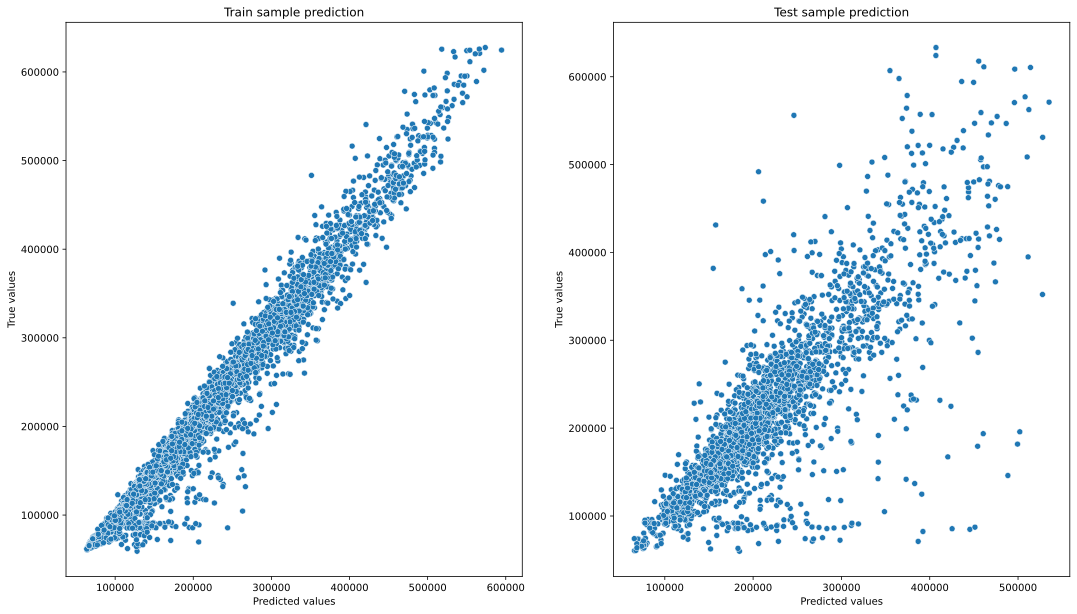

In [3368]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)


evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [3369]:
%%time
# Выполним обучение модели с кросс-валидацией
cv = cross_validate(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True))

Средняя эффективность по метрике r2: 0.7090877200527972
CPU times: total: 11.4 s
Wall time: 11.9 s


In [3371]:
print(f'Средняя эффективность по метрике r2: {cv["test_score"].mean()}')

Средняя эффективность по метрике r2: 0.7090877200527972


In [3370]:
import sys
sys.exit()

SystemExit: 

In [3372]:
X_valid.head(5)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,LifeSquare_nan,Rooms_outlier,Floor_outlier
6252,3702,21,2.0,49.0,35.0,5.0,5,5.0,1963,0.034331,...,1,25,5487,3,0,4,1,0,0,0
4684,12848,61,3.0,81.0,49.0,8.0,4,4.0,1960,0.298205,...,1,16,4048,3,1,3,1,0,0,0
1731,2239,6,3.0,83.0,4.0,1.0,8,17.0,1977,0.243205,...,1,5,1564,0,0,0,1,0,0,0
4742,15611,23,1.0,34.0,30.0,0.0,1,4.0,1977,0.034656,...,1,0,168,0,0,0,1,0,0,1
4521,5634,52,1.0,43.0,33.0,1.0,10,17.0,1977,0.371149,...,1,34,7065,1,2,5,1,1,0,0


In [3374]:
# построим новые признаки
features_gen = FeatureGenetator()

features_gen.fit(X_train, y_train)
X_train = features_gen.transform(X_train)

# features_gen.fit(X_valid, y_train)
X_valid = features_gen.transform(X_valid)

# features_gen.fit(test_df, y_train)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 28), (3000, 28), (5000, 28))

In [3375]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
# rf_model.fit(X_train, y_train)

In [3376]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3378]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

ValueError: X has 28 features, but RandomForestRegressor is expecting 21 features as input.

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)